In [57]:
import os

import matplotlib.pyplot as plt
import matplotlib.image as pltimg
%matplotlib inline

training_data_dir = './training_model_data/'
training_good_s = os.path.join(training_data_dir, 'good_soles')
training_bad_s = os.path.join(training_data_dir, 'bad_soles')

print('Training good soles: ', len(os.listdir(training_good_s)))
print('Training bad soles: ', len(os.listdir(training_bad_s)))

testing_data_dir = './test_model_data/'
testing_good_s = os.path.join(testing_data_dir, 'good_soles')
testing_bad_s = os.path.join(testing_data_dir, 'bad_soles')

print('Testing good soles: ', len(os.listdir(testing_good_s)))
print('Testing bad soles: ', len(os.listdir(testing_bad_s)))

Training good soles:  47
Training bad soles:  33
Testing good soles:  28
Testing bad soles:  23


In [58]:
from tensorflow.keras import layers
from tensorflow.keras import Model

In [59]:
# Our input feature map is 150x150x3: 150x150 for the image pixels, and 3 for
# the three color channels: R, G, and B
img_input = layers.Input(shape=(150, 150, 3))

# First convolution extracts 16 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(16, 3, activation='relu')(img_input)
x = layers.MaxPooling2D(2)(x)

# Second convolution extracts 32 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

# Third convolution extracts 64 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

In [60]:
# Flatten feature map to a 1-dim tensor so we can add fully connected layers
x = layers.Flatten()(x)

# Create a fully connected layer with ReLU activation and 512 hidden units
x = layers.Dense(512, activation='relu')(x)

# Create output layer with a single node and sigmoid activation
output = layers.Dense(1, activation='sigmoid')(x)

# Create model:
# input = input feature map
# output = input feature map + stacked convolution/maxpooling layers + fully 
# connected layer + sigmoid output layer
model = Model(img_input, output)

In [61]:
model.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 148, 148, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 74, 74, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 72, 72, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 36, 36, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 34, 34, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 17, 17, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 18496)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 512)            │     9,470,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,494,561 (36.22 MB)

 Trainable params: 9,494,561 (36.22 MB)

 Non-trainable params: 0 (0.00 B)

In [62]:
from tensorflow.keras.optimizers import RMSprop

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(learning_rate=0.001),
              metrics=['acc'])

In [63]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        training_data_dir,  # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=10,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

Found 59 images belonging to 2 classes.


In [64]:
val_datagen = ImageDataGenerator(rescale=1./255)
# Flow validation images in batches of 20 using val_datagen generator
validation_generator = val_datagen.flow_from_directory(
        testing_data_dir,
        target_size=(150, 150),
        batch_size=10,
        class_mode='binary')

Found 39 images belonging to 2 classes.


In [65]:
history = model.fit(
      train_generator,
      steps_per_epoch=5,  # 2000 images = batch_size * steps
      epochs=25,
      validation_data=validation_generator,
      validation_steps=5,  # 1000 images = batch_size * steps
      verbose=2)

Epoch 1/25
5/5 - 3s - 636ms/step - acc: 0.3673 - loss: 1.5355 - val_acc: 0.5897 - val_loss: 0.5318
Epoch 2/25
5/5 - 1s - 183ms/step - acc: 0.6000 - loss: 0.3256 - val_acc: 0.5897 - val_loss: 0.5370
Epoch 3/25
5/5 - 2s - 342ms/step - acc: 0.6327 - loss: 0.6763 - val_acc: 0.5897 - val_loss: 0.5400
Epoch 4/25
5/5 - 1s - 178ms/step - acc: 0.5000 - loss: 0.3807 - val_acc: 0.5897 - val_loss: 0.5317
Epoch 5/25
5/5 - 2s - 446ms/step - acc: 0.6327 - loss: 0.6491 - val_acc: 0.5897 - val_loss: 0.5493
Epoch 6/25
5/5 - 1s - 256ms/step - acc: 0.5000 - loss: 0.3994 - val_acc: 0.5897 - val_loss: 0.5327
Epoch 7/25
5/5 - 2s - 476ms/step - acc: 0.6531 - loss: 0.6450 - val_acc: 0.5897 - val_loss: 0.5514
Epoch 8/25
5/5 - 1s - 230ms/step - acc: 0.4000 - loss: 0.3974 - val_acc: 0.5897 - val_loss: 0.5305
Epoch 9/25
5/5 - 2s - 484ms/step - acc: 0.6400 - loss: 0.6536 - val_acc: 0.5897 - val_loss: 0.5274
Epoch 10/25
5/5 - 1s - 231ms/step - acc: 0.4444 - loss: 0.3690 - val_acc: 0.5897 - val_loss: 0.5303
Epoch 11/

Text(0.5, 1.0, 'Training and validation loss')

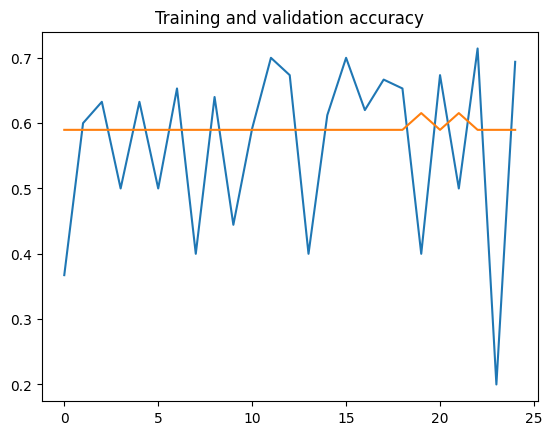

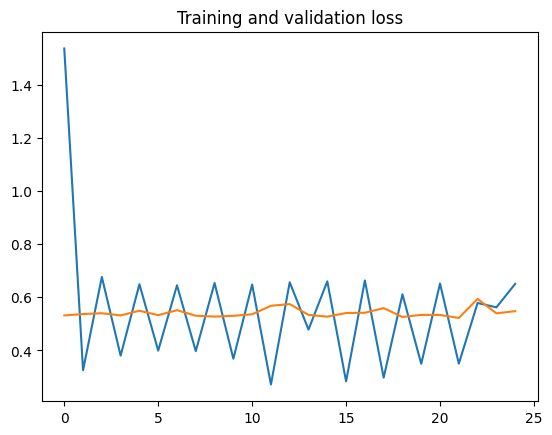

In [66]:
# Retrieve a list of accuracy results on training and validation data
# sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieve a list of list results on training and validation data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.legend(labels)
plt.title('Training and validation loss')